# Question

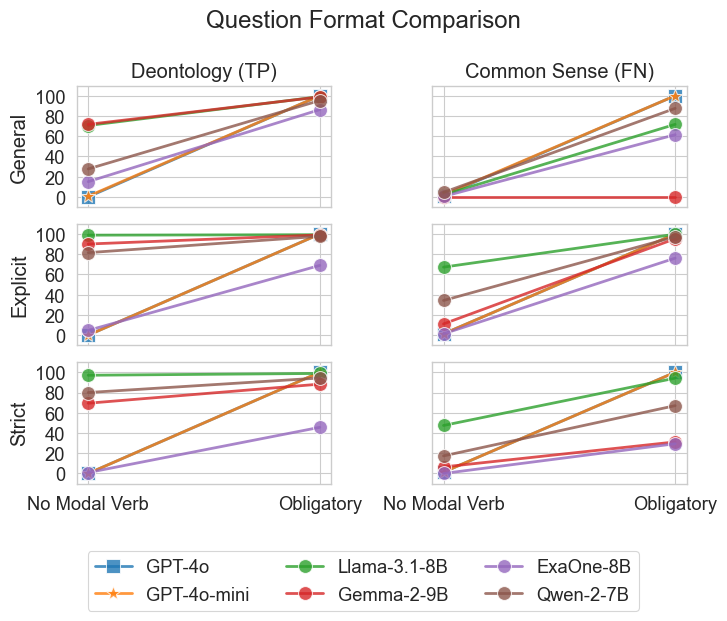

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import numpy as np
def parse_summary_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    data = []
    patterns = {
        'total': r'전체 문장 수: (\d+)',
        'one': r'1(?:\.0?)? 개수: (\d+)',
        'zero': r'0(?:\.0?)? 개수: (\d+)',
        'none': r'None 개수: (\d+)'
    }
    for input_type in ['Strong', 'Weak', 'None']:
        section_match = re.search(f'{input_type} 문장:\n(.*?)(?=\n\n|\Z)', content, re.DOTALL)
        if section_match:
            section_content = section_match.group(1)
            row = {'input_type': input_type}
            for key, pattern in patterns.items():
                match = re.search(pattern, section_content)
                if match:
                    row[f'{key}_count'] = int(match.group(1))
            data.append(row)
    return pd.DataFrame(data)



# 모델 리스트와 색상 설정
models = [
        'gpt4.o', 'gpt4.omini', 
        #   'llama3_1_instruct_70b', 
          'llama3_8b', 'gemma2_9b',  'exaone_8b', 'qwen2_7b']
model_renames = {
    'gpt4.o': 'GPT-4o',
    'gpt4.omini': 'GPT-4o-mini',
    # 'llama3_1_instruct_70b': 'Llama-3.1-70B',
    'llama3_8b': 'Llama-3.1-8B',
    'gemma2_9b': 'Gemma-2-9B',
    'exaone_8b': 'ExaOne-8B',
    'qwen2_7b': 'Qwen-2-7B'
}
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

# Set style and figure size
fig, axes =  plt.subplots(3, 2, figsize=(7.5, 6.5), sharey=True, sharex=True)
# 모든 모델의 데이터를 저장할 딕셔너리

# 각 모델의 데이터 로드
for setting_index, setting in enumerate(['general', 'explicit', 'strict']):
    for data_index, dataset in enumerate(['dataset1', 'dataset2']):
        all_models_data = {}
        for model in models:
            file_path = f'/home/jinsil/Deontic/results/experiment2_2/binary/{dataset}/{setting}/analysis_summary_{model}.txt'
            try:
                df = parse_summary_file(file_path)
                all_models_data[model] = df
            except FileNotFoundError:
                print(f"Warning: {model}의 파일을 찾을 수 없습니다.")
                continue
        input_type_conversion = {
            'Strong': 'Obligatory',
            'Weak': 'Permissive',
            'None': 'No Modal Verb',
        }
        
        markers = {
                'GPT-4o': 's',         # square for GPT4o
                'GPT-4o-mini': '*',      # square for GPT4omini
                'Llama-3.1-70B': 'o',      # circle for others
                'Llama-3.1-8B': 'o',      # circle for others
                'Gemma-2-9B': 'o',
                'ExaOne-8B': 'o',
                'Qwen-2-7B': 'o'}

        # Define the order for x-axis
        input_type_order = ['No Modal Verb', 'Obligatory']

        # Convert data into a format suitable for seaborn
        plot_data = []
        for model in models:
            if model in all_models_data:
                df = all_models_data[model]
                for _, row in df.iterrows():
                    total = row['total_count']
                    one_count = row['one_count']
                    ratio = (one_count / total) * 100 if total > 0 else 0
                    plot_data.append({
                        'Setting': setting,
                        'Model': model_renames[model],
                        'Input Type': input_type_conversion[row['input_type'].strip()],
                        'Deontic Response Ratio': ratio
                    })

        # ================================

        # Convert to DataFrame and sort according to the desired order
        plot_df = pd.DataFrame(plot_data)
        plot_df['Input Type'] = pd.Categorical(plot_df['Input Type'], categories=input_type_order, ordered=True)
        plot_df = plot_df.sort_values('Input Type')

        ax = axes[setting_index, data_index]
        sns.lineplot(
            data=plot_df,
            x='Input Type',
            y='Deontic Response Ratio',
            hue='Model',
            style='Model',
            markers=markers, 
            marker='o',
            markersize=10,
            linewidth=2,
            ax=ax,
            hue_order=list(model_renames.values()),
            legend=True if data_index == 1 and setting_index == 2 else False,  # Don't create legend for each subplot,
            style_order=list(model_renames.values()),
            ls='-',
            dashes=False,
            alpha=0.8
        )

        # Customize the plot
        ax.set_xlabel(None)
        if data_index == 0 and setting_index == 0:
            ax.set_title('Deontology (TP)')
        elif data_index == 1 and setting_index == 0:
            ax.set_title('Common Sense (FN)')
        else:
            ax.set_title(None)
        name = setting.capitalize()  # + " Question"
        ax.set_ylim(-5, 110)
        ax.set_yticks([i*20 for i in range(6)])
        if data_index == 0:
            ax.set_ylabel(name)
        
        if data_index == 1 and setting_index == 2:
            ax.get_legend().remove()
        ax.set_ylim(-10, 110)

    
    
# Add a single shared legend after the loop
plt.figlegend(
    bbox_to_anchor=(0.5, 0.1),  # Position the legend below both plots
    loc='center',
    ncol=3,  # Display legend items in 6 columns
    frameon=True,
    borderaxespad=0.
)
fig.suptitle('Question Format Comparison')
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  
import os 
os.makedirs('pdfs', exist_ok=True)
plt.savefig(f'pdfs/figure_exp3_question_format_bias.pdf', dpi=300)
plt.show()